In [1]:
import pandas as pd
from datetime import datetime, timedelta
pd.set_option('max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm_notebook as tqdm

import lightgbm as lgb

import gc

# Препроцессинг

In [2]:
# Конвертируем строки во время
def parse_dt(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

In [3]:
# путь к данным
path = 'work/'

In [4]:
# Загрузка
data = pd.read_csv(path + 'dataset_no_2018.csv', encoding='cp1251', index_col=[0])

/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
data['date'] = data['date'].apply(parse_dt)

In [6]:
data.head()

,date,RF.21304.Ток...213MII904A,S.C.ВПУСК.ПП.ДАВЛ...214PI226AA,S.C.ВПУСК.ПП.ДАВЛ...214PI226AB,S.C.ВПУСК.ПП.ТЕМП...214TI232A,SPEED.CONTROLLER...250MSIC001.PV,XX21401.МАСС.РАСХ.ГРАНУЛ...214FIC112.PV,ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A,ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981,Е.21402А....ГР.ВОДА.ВЫХ...214TIC101A,ЕХ21401.АЕ01.MFR...214AI200A,НАГНЕТАНИЕ.В.EX.21401...250PI001,ПОЛОЖ.НОЖА..ГРАНУЛЯТОРА...214ZI211A,ПОЛОЖ.ЩЕЛ.ДИСКА...214ZI202A,РАСХОД.В....EX.21401...250FIC001.PV,РАСХОД.ЛИНИИ.P.W...214FI205A,СЕКТ.ПИТАТЕЛЬ.RF21304...213MSIC904.PV,СПЕЦ.ЭНЕРГИЯ...214JYY200A,ТЕМП.ЛИН.Г.В..ДР.ЛИН....214TI247A,ТЕМП.ЛИН.Г.В..ЛИН.РАЗ....214TI246A,ТЕМП.ФИЛЬЕРЫ...214TI235A,ТЕМП.ЩЕЛ.ДИСК.УПР...214TIC214A,ТЕМПЕРАТУРА.EX.21401...250TI004,ТЕМПЕРАТУРА.ОБОРОТН.ВОДЫ...250TIC003.PV,ТОК.ДВИГ.ГРАНУЛЯТ...214II217A,УПРАВЛЕНИЕ..P.25001A...250HIC001A,УРОВЕНЬ.В...V.25001A...250LI001A,ФАКТ.РАСХОД.ПРОП...213FY070,ФАКТ.РАСХОД.ПРОП...213FY070_R,ФИЛЬЕРА.ПП.ДАВЛ...214PI227AA,ФИЛЬЕРА.ПП.ДАВЛ...214PI227AB,ФИЛЬЕРА.ПП.ТЕМП...214TI233A,ЦИЛ..2.ТЕМП.УПР...214TIC206A,ЦИЛ..3.ТЕМП.НАГР...214TI216A,ЦИЛ..3.ТЕМП.УПР...214TIC207A,ЦИЛ..4.ТЕМП.УПР...214TIC208A,ЦИЛ..5.ТЕМП.УПР...214TIC209A,ЦИЛ..6.ТЕМП.УПР...214TIC210A,ЦИЛ..7.ТЕМП.УПР...214TIC211A,ЦИЛ..8.ТЕМП.УПР...214TIC212A,ЦИЛ..9.ТЕМП.УПР...214TIC213A,ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A,ЭКСТР.ДВИГ.ПОТОК...214II200A,H2.C3..КОНТР.СООТН...212AIC008.PV
0,2017-01-01 00:00:10,NaN,14.880000,14.860000,256.100006,0.0,NaN,0.5277,NaN,52.0,NaN,NaN,7.33,69.700005,NaN,573.400024,NaN,NaN,NaN,281.600006,212.400009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.89,6.79,252.600006,NaN,384.200012,153.300003,240.100006,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN
1,2017-01-01 00:00:20,NaN,14.880000,14.839999,256.000000,0.0,NaN,0.5277,NaN,52.0,NaN,NaN,7.33,69.700005,NaN,584.100037,NaN,NaN,NaN,281.800018,212.300003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.89,6.78,252.500000,NaN,384.200012,153.300003,240.199997,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN
2,2017-01-01 00:00:30,NaN,14.870000,14.820000,256.000000,0.0,NaN,0.5277,NaN,52.0,NaN,NaN,7.33,69.700005,NaN,582.400024,NaN,NaN,NaN,281.600006,212.400009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.88,6.78,252.500000,NaN,384.200012,153.400009,240.199997,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN
3,2017-01-01 00:00:40,NaN,14.889999,14.870000,256.100006,0.0,NaN,0.5277,NaN,52.0,NaN,NaN,7.33,69.700005,NaN,586.299988,NaN,NaN,NaN,281.700012,212.400009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.89,6.79,252.500000,NaN,384.200012,153.400009,240.199997,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN
4,2017-01-01 00:00:50,NaN,14.880000,14.830000,256.100006,0.0,NaN,0.5277,NaN,52.0,NaN,NaN,7.33,69.700005,NaN,579.200012,NaN,NaN,NaN,281.800018,212.400009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.87,6.78,252.600006,NaN,384.200012,153.400009,240.199997,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN


In [7]:
data.shape

(3153599, 44)

In [8]:
# Рабочие колонки
roll_cols = ['RF.21304.Ток...213MII904A', 'S.C.ВПУСК.ПП.ДАВЛ...214PI226AA',
       'S.C.ВПУСК.ПП.ДАВЛ...214PI226AB', 'S.C.ВПУСК.ПП.ТЕМП...214TI232A',
       'XX21401.МАСС.РАСХ.ГРАНУЛ...214FIC112.PV',
       'ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A',
       'Е.21402А....ГР.ВОДА.ВЫХ...214TIC101A', 'ЕХ21401.АЕ01.MFR...214AI200A',
       'НАГНЕТАНИЕ.В.EX.21401...250PI001',
       'ПОЛОЖ.НОЖА..ГРАНУЛЯТОРА...214ZI211A', 'ПОЛОЖ.ЩЕЛ.ДИСКА...214ZI202A',
       'РАСХОД.В....EX.21401...250FIC001.PV', 'РАСХОД.ЛИНИИ.P.W...214FI205A',
       'СПЕЦ.ЭНЕРГИЯ...214JYY200A',
       'ТЕМП.ЛИН.Г.В..ДР.ЛИН....214TI247A',
       'ТЕМП.ЛИН.Г.В..ЛИН.РАЗ....214TI246A', 'ТЕМП.ФИЛЬЕРЫ...214TI235A',
       'ТЕМП.ЩЕЛ.ДИСК.УПР...214TIC214A', 'ТЕМПЕРАТУРА.EX.21401...250TI004',
       'ТЕМПЕРАТУРА.ОБОРОТН.ВОДЫ...250TIC003.PV',
       'ТОК.ДВИГ.ГРАНУЛЯТ...214II217A', 'УПРАВЛЕНИЕ..P.25001A...250HIC001A',
       'УРОВЕНЬ.В...V.25001A...250LI001A', 'ФАКТ.РАСХОД.ПРОП...213FY070',
       'ФАКТ.РАСХОД.ПРОП...213FY070_R', 'ФИЛЬЕРА.ПП.ДАВЛ...214PI227AA',
       'ФИЛЬЕРА.ПП.ДАВЛ...214PI227AB', 'ФИЛЬЕРА.ПП.ТЕМП...214TI233A',
       'ЦИЛ..2.ТЕМП.УПР...214TIC206A', 'ЦИЛ..3.ТЕМП.НАГР...214TI216A',
       'ЦИЛ..3.ТЕМП.УПР...214TIC207A', 'ЦИЛ..4.ТЕМП.УПР...214TIC208A',
       'ЦИЛ..5.ТЕМП.УПР...214TIC209A', 'ЦИЛ..6.ТЕМП.УПР...214TIC210A',
       'ЦИЛ..7.ТЕМП.УПР...214TIC211A', 'ЦИЛ..8.ТЕМП.УПР...214TIC212A',
       'ЦИЛ..9.ТЕМП.УПР...214TIC213A', 'ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A',
       'ЭКСТР.ДВИГ.ПОТОК...214II200A', 'H2.C3..КОНТР.СООТН...212AIC008.PV']

In [9]:
# Генерируем фичи со взглядом назад на час, на два, на три, гна шесть, на десять
new_cols = []
for t in tqdm([1, 2, 3, 6, 10]):
    for col in roll_cols:
        data[col + str(t) +'h_mean'] = data[col].rolling(360*t).mean().shift(1)
        new_cols.append(col + str(t) +'h_mean')
        
        data[col + str(t) +'h_std'] = data[col].rolling(360*t).std().shift(1)
        new_cols.append(col + str(t) +'h_std')
        
        data[col + str(t) +'h_min'] = data[col].rolling(360*t).min().shift(1)
        new_cols.append(col + str(t) +'h_min')
        
        data[col + str(t) +'h_max'] = data[col].rolling(360*t).min().shift(1)
        new_cols.append(col + str(t) +'h_max')

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [10]:
# В качестве аномалии берем большую дисперсию параметра 'ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981' - который
# характеризует частоту оборотов гранулятора. Расчитываем этот параметр на час вперед
STEP = int(60*60/10)
data['target'] = data['ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981'].rolling(STEP).var().shift(-STEP)

In [11]:
data.dropna(inplace=True, subset=['target'])

In [12]:
data.head()

,date,RF.21304.Ток...213MII904A,S.C.ВПУСК.ПП.ДАВЛ...214PI226AA,S.C.ВПУСК.ПП.ДАВЛ...214PI226AB,S.C.ВПУСК.ПП.ТЕМП...214TI232A,SPEED.CONTROLLER...250MSIC001.PV,XX21401.МАСС.РАСХ.ГРАНУЛ...214FIC112.PV,ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A,ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981,Е.21402А....ГР.ВОДА.ВЫХ...214TIC101A,ЕХ21401.АЕ01.MFR...214AI200A,НАГНЕТАНИЕ.В.EX.21401...250PI001,ПОЛОЖ.НОЖА..ГРАНУЛЯТОРА...214ZI211A,ПОЛОЖ.ЩЕЛ.ДИСКА...214ZI202A,РАСХОД.В....EX.21401...250FIC001.PV,РАСХОД.ЛИНИИ.P.W...214FI205A,СЕКТ.ПИТАТЕЛЬ.RF21304...213MSIC904.PV,СПЕЦ.ЭНЕРГИЯ...214JYY200A,ТЕМП.ЛИН.Г.В..ДР.ЛИН....214TI247A,ТЕМП.ЛИН.Г.В..ЛИН.РАЗ....214TI246A,ТЕМП.ФИЛЬЕРЫ...214TI235A,ТЕМП.ЩЕЛ.ДИСК.УПР...214TIC214A,ТЕМПЕРАТУРА.EX.21401...250TI004,ТЕМПЕРАТУРА.ОБОРОТН.ВОДЫ...250TIC003.PV,ТОК.ДВИГ.ГРАНУЛЯТ...214II217A,УПРАВЛЕНИЕ..P.25001A...250HIC001A,УРОВЕНЬ.В...V.25001A...250LI001A,ФАКТ.РАСХОД.ПРОП...213FY070,ФАКТ.РАСХОД.ПРОП...213FY070_R,ФИЛЬЕРА.ПП.ДАВЛ...214PI227AA,ФИЛЬЕРА.ПП.ДАВЛ...214PI227AB,ФИЛЬЕРА.ПП.ТЕМП...214TI233A,ЦИЛ..2.ТЕМП.УПР...214TIC206A,ЦИЛ..3.ТЕМП.НАГР...214TI216A,ЦИЛ..3.ТЕМП.УПР...214TIC207A,ЦИЛ..4.ТЕМП.УПР...214TIC208A,ЦИЛ..5.ТЕМП.УПР...214TIC209A,ЦИЛ..6.ТЕМП.УПР...214TIC210A,ЦИЛ..7.ТЕМП.УПР...214TIC211A,ЦИЛ..8.ТЕМП.УПР...214TIC212A,ЦИЛ..9.ТЕМП.УПР...214TIC213A,ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A,ЭКСТР.ДВИГ.ПОТОК...214II200A,H2.C3..КОНТР.СООТН...212AIC008.PV,RF.21304.Ток...213MII904A1h_mean,RF.21304.Ток...213MII904A1h_std,RF.21304.Ток...213MII904A1h_min,RF.21304.Ток...213MII904A1h_max,S.C.ВПУСК.ПП.ДАВЛ...214PI226AA1h_mean,S.C.ВПУСК.ПП.ДАВЛ...214PI226AA1h_std,...,ФИЛЬЕРА.ПП.ТЕМП...214TI233A10h_max,ЦИЛ..2.ТЕМП.УПР...214TIC206A10h_mean,ЦИЛ..2.ТЕМП.УПР...214TIC206A10h_std,ЦИЛ..2.ТЕМП.УПР...214TIC206A10h_min,ЦИЛ..2.ТЕМП.УПР...214TIC206A10h_max,ЦИЛ..3.ТЕМП.НАГР...214TI216A10h_mean,ЦИЛ..3.ТЕМП.НАГР...214TI216A10h_std,ЦИЛ..3.ТЕМП.НАГР...214TI216A10h_min,ЦИЛ..3.ТЕМП.НАГР...214TI216A10h_max,ЦИЛ..3.ТЕМП.УПР...214TIC207A10h_mean,ЦИЛ..3.ТЕМП.УПР...214TIC207A10h_std,ЦИЛ..3.ТЕМП.УПР...214TIC207A10h_min,ЦИЛ..3.ТЕМП.УПР...214TIC207A10h_max,ЦИЛ..4.ТЕМП.УПР...214TIC208A10h_mean,ЦИЛ..4.ТЕМП.УПР...214TIC208A10h_std,ЦИЛ..4.ТЕМП.УПР...214TIC208A10h_min,ЦИЛ..4.ТЕМП.УПР...214TIC208A10h_max,ЦИЛ..5.ТЕМП.УПР...214TIC209A10h_mean,ЦИЛ..5.ТЕМП.УПР...214TIC209A10h_std,ЦИЛ..5.ТЕМП.УПР...214TIC209A10h_min,ЦИЛ..5.ТЕМП.УПР...214TIC209A10h_max,ЦИЛ..6.ТЕМП.УПР...214TIC210A10h_mean,ЦИЛ..6.ТЕМП.УПР...214TIC210A10h_std,ЦИЛ..6.ТЕМП.УПР...214TIC210A10h_min,ЦИЛ..6.ТЕМП.УПР...214TIC210A10h_max,ЦИЛ..7.ТЕМП.УПР...214TIC211A10h_mean,ЦИЛ..7.ТЕМП.УПР...214TIC211A10h_std,ЦИЛ..7.ТЕМП.УПР...214TIC211A10h_min,ЦИЛ..7.ТЕМП.УПР...214TIC211A10h_max,ЦИЛ..8.ТЕМП.УПР...214TIC212A10h_mean,ЦИЛ..8.ТЕМП.УПР...214TIC212A10h_std,ЦИЛ..8.ТЕМП.УПР...214TIC212A10h_min,ЦИЛ..8.ТЕМП.УПР...214TIC212A10h_max,ЦИЛ..9.ТЕМП.УПР...214TIC213A10h_mean,ЦИЛ..9.ТЕМП.УПР...214TIC213A10h_std,ЦИЛ..9.ТЕМП.УПР...214TIC213A10h_min,ЦИЛ..9.ТЕМП.УПР...214TIC213A10h_max,ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A10h_mean,ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A10h_std,ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A10h_min,ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A10h_max,ЭКСТР.ДВИГ.ПОТОК...214II200A10h_mean,ЭКСТР.ДВИГ.ПОТОК...214II200A10h_std,ЭКСТР.ДВИГ.ПОТОК...214II200A10h_min,ЭКСТР.ДВИГ.ПОТОК...214II200A10h_max,H2.C3..КОНТР.СООТН...212AIC008.PV10h_mean,H2.C3..КОНТР.СООТН...212AIC008.PV10h_std,H2.C3..КОНТР.СООТН...212AIC008.PV10h_min,H2.C3..КОНТР.СООТН...212AIC008.PV10h_max,target
77758,2017-01-09 23:59:50,NaN,9.410000,9.12,239.800003,38.869999,NaN,0.5314,NaN,51.0,NaN,NaN,7.99,23.0,NaN,588.400024,NaN,NaN,NaN,281.800018,209.300003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.44,3.49,240.199997,NaN,340.399994,156.400009,244.900009,240.699997,225.199997,181.600006,181.100006,183.199997,5410.0,NaN,NaN,NaN,NaN,NaN,NaN,9.262028,0.099732,...,198.900009,NaN,NaN,NaN,NaN,325.365642,43.161517,193.0,193.0,167.911781,30.641831,141.400009,141.400009,244.854614,7.352478,225.5,225.5,241.125253,8.060223,227.0,227.0,231.186114,13.622411,214.600006,214.600006,204.566976,31.655433,174.900009,174.900009,204.263809,30.991744,178.300003,178.

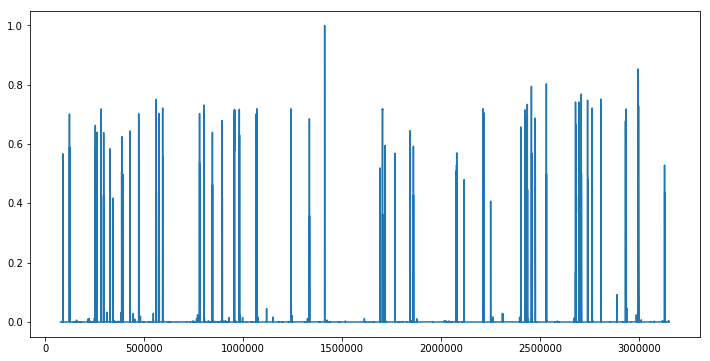

In [18]:
plt.figure(figsize=(12, 6))
target_max = data.target.max()
roll_var_norm = data.target/target_max
roll_var_norm.plot()

In [19]:
# в качестве порога берем 0.2
target_max = data.target.max()
data['TARGET'] = np.where(data.target/target_max >= 0.2, 1, 0)

### SIMPLE LGBM

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
y=data['TARGET']

In [22]:
X_t, X_te, y_t, y_te=train_test_split(data[roll_cols+new_cols], y, shuffle=False, test_size=0.25)

In [23]:
gc.collect()

106

In [24]:
lgtrain = lgb.Dataset(X_t, y_t,
                feature_name=roll_cols+new_cols,
                #categorical_feature = categorical
                      )
lgvalid = lgb.Dataset(X_te, y_te,
                feature_name=roll_cols+new_cols
                #categorical_feature = categorical
                      )

In [25]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 5,
    # 'num_leaves': 31,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    # 'bagging_freq': 5,
    'learning_rate': 0.02,
    'num_threads': 16,
    'verbose': 1}

In [26]:
lgb_r = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=300,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=50,
    verbose_eval=50
)

Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.898124	valid's auc: 0.829582
[100]	train's auc: 0.924012	valid's auc: 0.831368
[150]	train's auc: 0.958465	valid's auc: 0.878196
Early stopping, best iteration is:
[147]	train's auc: 0.958364	valid's auc: 0.87831


In [27]:
lgb_r.feature_importance().max()

117

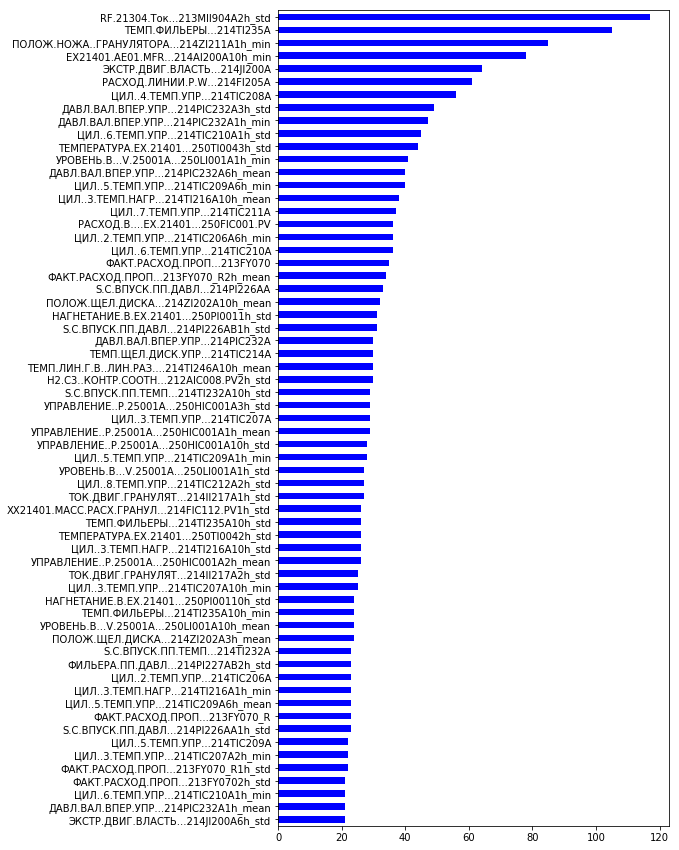

In [28]:
best_clf_features = pd.Series(lgb_r.feature_importance(), index=roll_cols+new_cols).sort_values()
treshold = 20
plt.figure(figsize=(7,15))
best_clf_features[best_clf_features>treshold].plot(kind='barh', color='blue')

In [29]:
del lgtrain, lgvalid
gc.collect()

27

## Отберем 50 лучших признаков и обучимся на них

In [30]:
best_cols = list(best_clf_features.nlargest(50).index)

In [31]:
best_clf_features.nlargest(50)

RF.21304.Ток...213MII904A2h_std                  117
ТЕМП.ФИЛЬЕРЫ...214TI235A                         105
ПОЛОЖ.НОЖА..ГРАНУЛЯТОРА...214ZI211A1h_min         85
ЕХ21401.АЕ01.MFR...214AI200A10h_min               78
ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A                     64
РАСХОД.ЛИНИИ.P.W...214FI205A                      61
ЦИЛ..4.ТЕМП.УПР...214TIC208A                      56
ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A3h_std              49
ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A1h_min              47
ЦИЛ..6.ТЕМП.УПР...214TIC210A1h_std                45
ТЕМПЕРАТУРА.EX.21401...250TI0043h_std             44
УРОВЕНЬ.В...V.25001A...250LI001A1h_min            41
ЦИЛ..5.ТЕМП.УПР...214TIC209A6h_min                40
ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A6h_mean             40
ЦИЛ..3.ТЕМП.НАГР...214TI216A10h_mean              38
ЦИЛ..7.ТЕМП.УПР...214TIC211A                      37
ЦИЛ..6.ТЕМП.УПР...214TIC210A                      36
ЦИЛ..2.ТЕМП.УПР...214TIC206A6h_min                36
РАСХОД.В....EX.21401...250FIC001.PV           

In [32]:
X_t, X_te, y_t, y_te = train_test_split(data[best_cols], y, shuffle=False, test_size=0.25)
gc.collect()
lgtrain = lgb.Dataset(X_t, y_t, feature_name=best_cols)
lgvalid = lgb.Dataset(X_te, y_te, feature_name=best_cols)

In [33]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 5,
    # 'num_leaves': 31,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    # 'bagging_freq': 5,
    'learning_rate': 0.02,
    'num_threads': 16,
    'verbose': 1}

In [34]:
lgb_r = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=300,
    valid_sets = [lgtrain, lgvalid],
    valid_names = ['train','valid'],
    early_stopping_rounds=50,
    verbose_eval=50
)

Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.896503	valid's auc: 0.830598
[100]	train's auc: 0.917579	valid's auc: 0.83529
[150]	train's auc: 0.957389	valid's auc: 0.858217
[200]	train's auc: 0.994401	valid's auc: 0.876655
[250]	train's auc: 0.999367	valid's auc: 0.867888
Early stopping, best iteration is:
[217]	train's auc: 0.99898	valid's auc: 0.881025


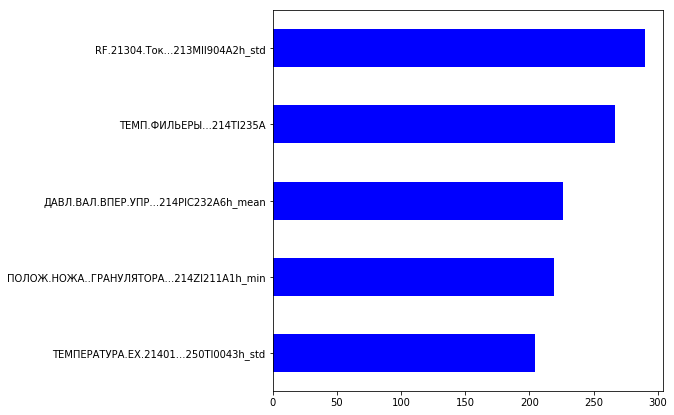

In [35]:
# Топ 5 признаков
best_clf_features = pd.Series(lgb_r.feature_importance(), index=best_cols).sort_values()
plt.figure(figsize=(7,7))
best_clf_features.nlargest(5)[::-1].plot(kind='barh', color='blue')

In [36]:
list(best_clf_features.nlargest(5)[::-1].index)

['ТЕМПЕРАТУРА.EX.21401...250TI0043h_std',
 'ПОЛОЖ.НОЖА..ГРАНУЛЯТОРА...214ZI211A1h_min',
 'ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A6h_mean',
 'ТЕМП.ФИЛЬЕРЫ...214TI235A',
 'RF.21304.Ток...213MII904A2h_std']

## confusion_matrix

In [37]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [38]:
y_pred = lgb_r.predict(X_te)
class_names = ['normal','anomaly']
y_pred_v=np.where(y_pred > 0.5, 1, 0)

Confusion matrix, without normalization
[[750810   3570]
 [  7758   6643]]


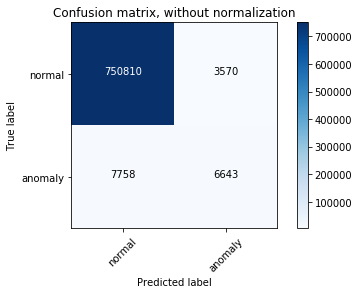

In [39]:
cnf_matrix = confusion_matrix(y_te, y_pred_v)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

## f1_score

In [40]:
from sklearn.metrics import f1_score

In [41]:
f1_score(y_te, y_pred_v)

0.5397741122938164

# EDA

In [8]:
def plot_series(data, cols, set_ylim=0.8,
                cond1=datetime.strptime('1900-01-15 10:22:22', '%Y-%m-%d %H:%M:%S'),
                cond2=datetime.strptime('9999-01-15 10:22:22', '%Y-%m-%d %H:%M:%S')
               ):
    d = data[cols+['date']].dropna()
    d = d[(d.date<cond2)&(d.date>cond1)]
    for col in cols:
        data_col_max = d[col].max()
        d[col] = [el/data_col_max for el in d[col]]
    plt.figure(figsize=(12, 6))
    for col in cols:
        plt.plot(d.date, d[col], label=col)
    plt.ylim([set_ylim, 1.01])
    plt.legend()
    print(d.date.min(), d.date.max())

In [9]:
def plot_series1(data, cols, 
                cond1=datetime.strptime('1900-01-15 10:22:22', '%Y-%m-%d %H:%M:%S'),
                cond2=datetime.strptime('9999-01-15 10:22:22', '%Y-%m-%d %H:%M:%S')
               ):
    d = data[cols+['date']].dropna()
    d = d[(d.date<cond2)&(d.date>cond1)]
    plt.figure(figsize=(12, 6))
    for col in cols:
        plt.plot(d.date, d[col], label=col)
    plt.legend()
    print(d.date.min(), d.date.max())

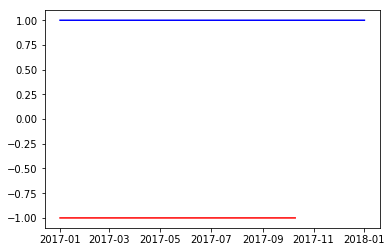

In [15]:
plt.plot(data.date, [1]*len(data.date), c='blue')
plt.plot(data.date[data.isnull().sum(axis=1)!=0], [-1]*len(data.date[data.isnull().sum(axis=1)!=0]), c='red')

2017-01-10 00:00:00 2017-01-11 11:03:50


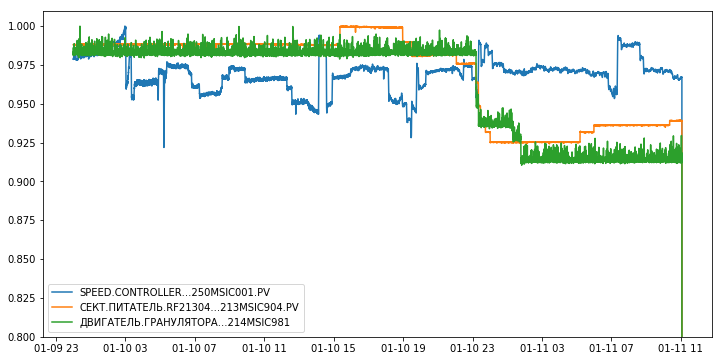

In [11]:
plot_series(data, ['SPEED.CONTROLLER...250MSIC001.PV', 
          'СЕКТ.ПИТАТЕЛЬ.RF21304...213MSIC904.PV', 
          'ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981'], 0.8, cond2='2017-01-11 11:04')

2017-01-10 00:00:00 2017-01-11 11:03:50


(0, 4)

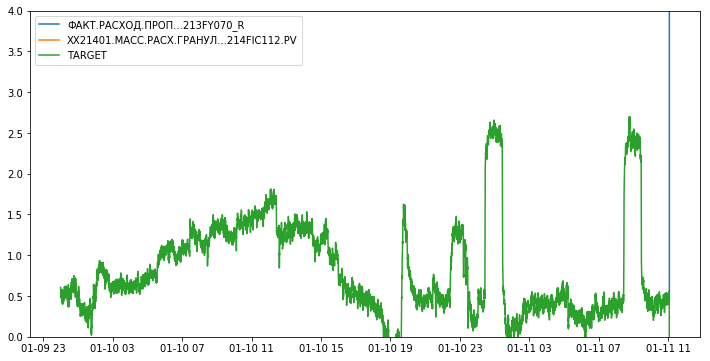

In [12]:
plot_series1(data, ['ФАКТ.РАСХОД.ПРОП...213FY070_R', 
                   'XX21401.МАСС.РАСХ.ГРАНУЛ...214FIC112.PV', 'TARGET'], cond2='2017-01-11 11:04')
plt.ylim(0, 4)

2017-01-10 00:00:00 2017-01-11 12:03:50


(27, 35)

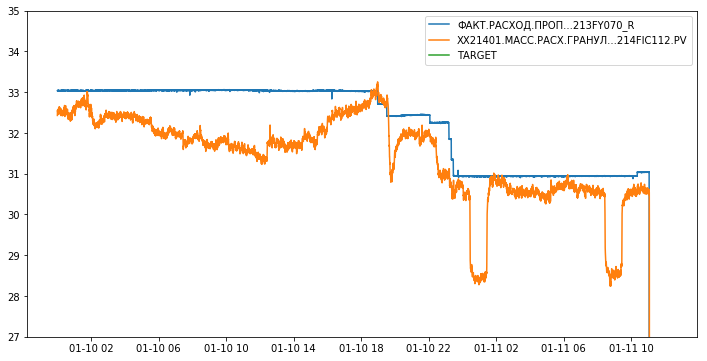

In [13]:
plot_series1(data, ['ФАКТ.РАСХОД.ПРОП...213FY070_R', 
                   'XX21401.МАСС.РАСХ.ГРАНУЛ...214FIC112.PV', 'TARGET'], cond2='2017-01-11 12:04')
plt.ylim(27, 35)

2017-01-10 00:00:00 2017-01-11 11:03:50


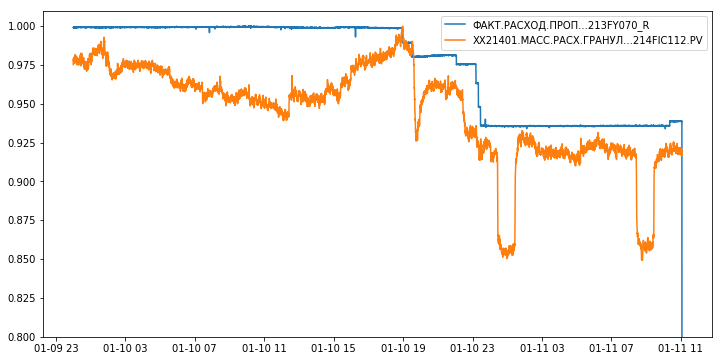

In [14]:
plot_series(data, ['ФАКТ.РАСХОД.ПРОП...213FY070_R', 
                   'XX21401.МАСС.РАСХ.ГРАНУЛ...214FIC112.PV'], 0.8, cond2='2017-01-11 11:04')

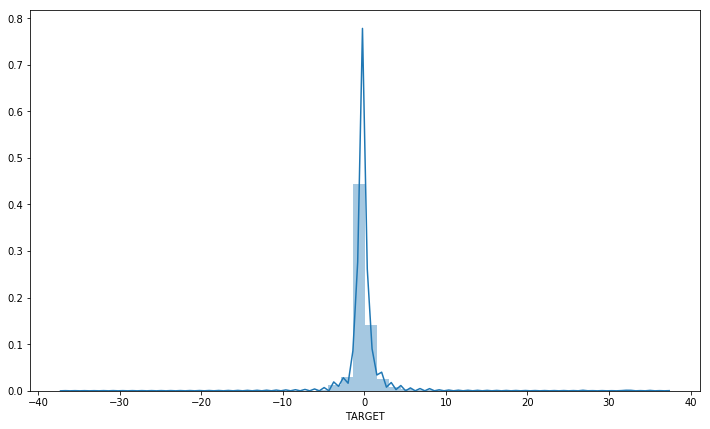

In [18]:
plt.figure(figsize=(12, 7))
sns.distplot(data.TARGET)

(0, 50)

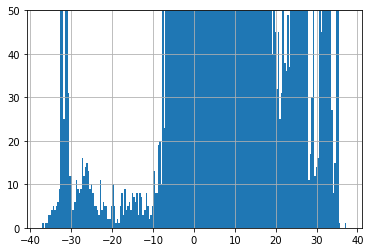

In [39]:
data.TARGET.hist(bins=200)
plt.ylim(0, 50)

2017-01-10 03:30:00 2017-01-11 11:03:50


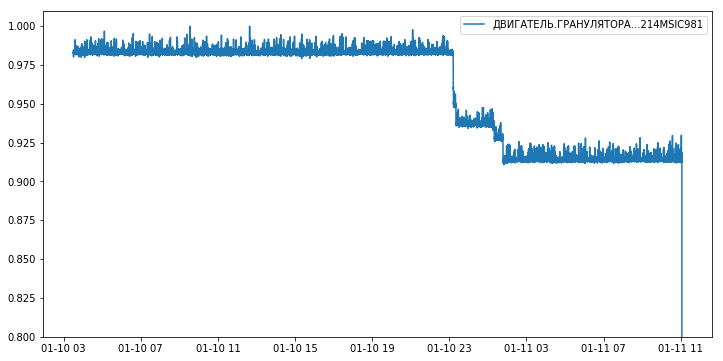

In [41]:
plot_series(data, ['ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981'], cond2='2017-01-11 11:04')

2017-01-10 03:30:00 2017-12-31 23:59:50


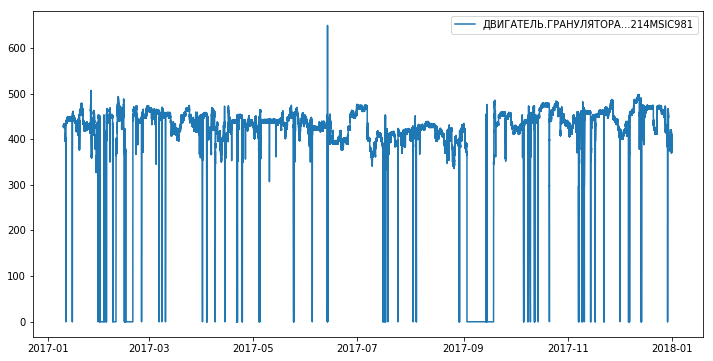

In [44]:
plot_series1(data, ['ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981'], cond2='2018-01-11 11:04')

2017-01-10 03:30:00 2017-01-11 23:59:50


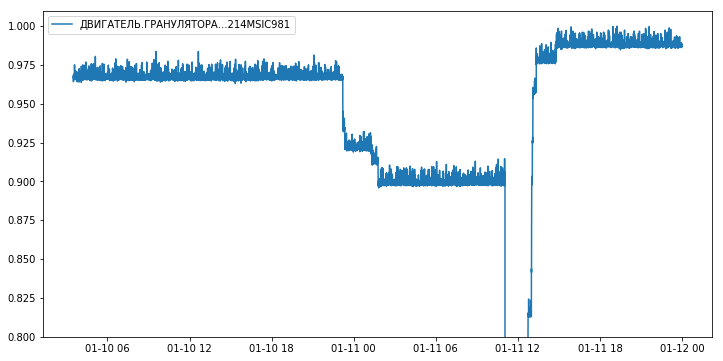

In [46]:
plot_series(data, ['ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981'], cond2='2017-01-12 00:00')

In [26]:
x=[datetime.strptime('2017-01-11 11:03', '%Y-%m-%d %H:%M'), 
datetime.strptime('2017-01-30 08:51', '%Y-%m-%d %H:%M'),
datetime.strptime('2017-02-24 17:45', '%Y-%m-%d %H:%M')]

2017-01-10 03:30:00 2017-02-24 23:59:50


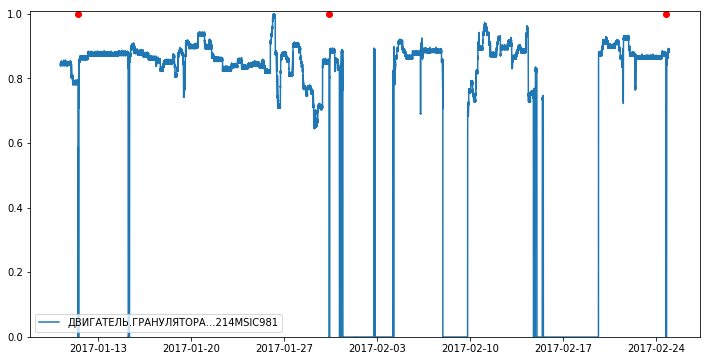

In [80]:
plot_series(data, ['ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981'], 0,cond1='2017-01-10 00:00', cond2='2017-02-25 00:00')
plt.scatter(x, [1]*len(x), c='red')

2017-01-12 00:00:10 2017-02-17 23:59:50


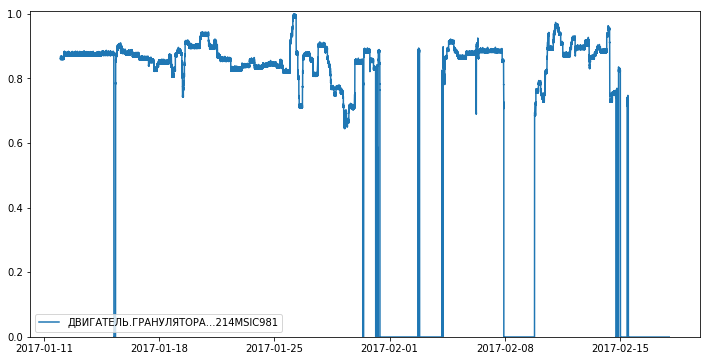

In [67]:
plot_series(data, ['ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981'], 0, cond1='2017-01-12 00:00', cond2='2017-02-18 00:00')

2017-01-15 05:00:10 2017-01-15 05:59:50


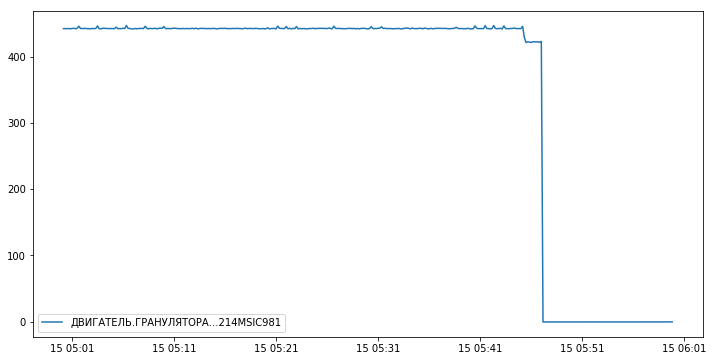

In [66]:
plot_series1(data, ['ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981'], cond1='2017-01-15 05:00', cond2='2017-01-15 06:00')

2017-01-15 06:00:10 2017-01-20 05:59:50


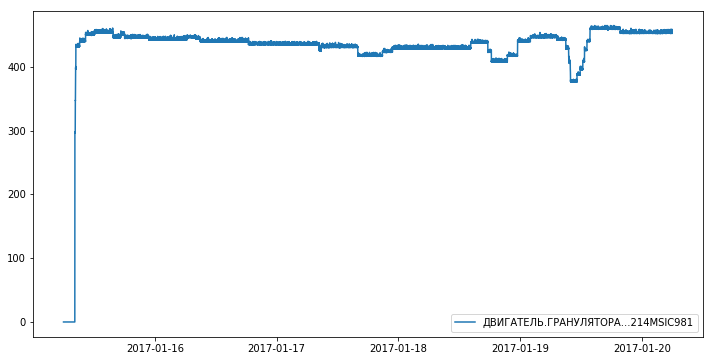

In [65]:
plot_series1(data, ['ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981'], cond1='2017-01-15 06:00', cond2='2017-01-20 06:00')

In [36]:
data.head()

,RF.21304.Ток...213MII904A,S.C.ВПУСК.ПП.ДАВЛ...214PI226AA,S.C.ВПУСК.ПП.ДАВЛ...214PI226AB,S.C.ВПУСК.ПП.ТЕМП...214TI232A,SPEED.CONTROLLER...250MSIC001.PV,XX21401.МАСС.РАСХ.ГРАНУЛ...214FIC112.PV,ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A,ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981,Е.21402А....ГР.ВОДА.ВЫХ...214TIC101A,ЕХ21401.АЕ01.MFR...214AI200A,НАГНЕТАНИЕ.В.EX.21401...250PI001,ПОЛОЖ.НОЖА..ГРАНУЛЯТОРА...214ZI211A,ПОЛОЖ.ЩЕЛ.ДИСКА...214ZI202A,РАСХОД.В....EX.21401...250FIC001.PV,РАСХОД.ЛИНИИ.P.W...214FI205A,СЕКТ.ПИТАТЕЛЬ.RF21304...213MSIC904.PV,СПЕЦ.ЭНЕРГИЯ...214JYY200A,ТЕМП.ЛИН.Г.В..ДР.ЛИН....214TI247A,ТЕМП.ЛИН.Г.В..ЛИН.РАЗ....214TI246A,ТЕМП.ФИЛЬЕРЫ...214TI235A,ТЕМП.ЩЕЛ.ДИСК.УПР...214TIC214A,ТЕМПЕРАТУРА.EX.21401...250TI004,ТЕМПЕРАТУРА.ОБОРОТН.ВОДЫ...250TIC003.PV,ТОК.ДВИГ.ГРАНУЛЯТ...214II217A,УПРАВЛЕНИЕ..P.25001A...250HIC001A,УРОВЕНЬ.В...V.25001A...250LI001A,ФАКТ.РАСХОД.ПРОП...213FY070,ФАКТ.РАСХОД.ПРОП...213FY070_R,ФИЛЬЕРА.ПП.ДАВЛ...214PI227AA,ФИЛЬЕРА.ПП.ДАВЛ...214PI227AB,ФИЛЬЕРА.ПП.ТЕМП...214TI233A,ЦИЛ..2.ТЕМП.УПР...214TIC206A,ЦИЛ..3.ТЕМП.НАГР...214TI216A,ЦИЛ..3.ТЕМП.УПР...214TIC207A,ЦИЛ..4.ТЕМП.УПР...214TIC208A,ЦИЛ..5.ТЕМП.УПР...214TIC209A,ЦИЛ..6.ТЕМП.УПР...214TIC210A,ЦИЛ..7.ТЕМП.УПР...214TIC211A,ЦИЛ..8.ТЕМП.УПР...214TIC212A,ЦИЛ..9.ТЕМП.УПР...214TIC213A,ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A,ЭКСТР.ДВИГ.ПОТОК...214II200A,H2.C3..КОНТР.СООТН...212AIC008.PV
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:10,NaN,14.880000,14.860000,256.100006,0.0,NaN,0.5277,NaN,52.0,NaN,NaN,7.33,69.700005,NaN,573.400024,NaN,NaN,NaN,281.600006,212.400009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.89,6.79,252.600006,NaN,384.200012,153.300003,240.100006,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN
2017-01-01 00:00:20,NaN,14.880000,14.839999,256.000000,0.0,NaN,0.5277,NaN,52.0,NaN,NaN,7.33,69.700005,NaN,584.100037,NaN,NaN,NaN,281.800018,212.300003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.89,6.78,252.500000,NaN,384.200012,153.300003,240.199997,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN
2017-01-01 00:00:30,NaN,14.870000,14.820000,256.000000,0.0,NaN,0.5277,NaN,52.0,NaN,NaN,7.33,69.700005,NaN,582.400024,NaN,NaN,NaN,281.600006,212.400009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.88,6.78,252.500000,NaN,384.200012,153.400009,240.199997,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN
2017-01-01 00:00:40,NaN,14.889999,14.870000,256.100006,0.0,NaN,0.5277,NaN,52.0,NaN,NaN,7.33,69.700005,NaN,586.299988,NaN,NaN,NaN,281.700012,212.400009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.89,6.79,252.500000,NaN,384.200012,153.400009,240.199997,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN
2017-01-01 00:00:50,NaN,14.880000,14.830000,256.100006,0.0,NaN,0.5277,NaN,52.0,NaN,NaN,7.33,69.700005,NaN,579.200012,NaN,NaN,NaN,281.800018,212.400009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.87,6.78,252.600006,NaN,384.200012,153.400009,240.199997,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN


In [20]:
roll_var = data['ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981'].rolling(int(60*60/10)).var()

In [22]:
roll_var_norm = roll_var/roll_var.max()

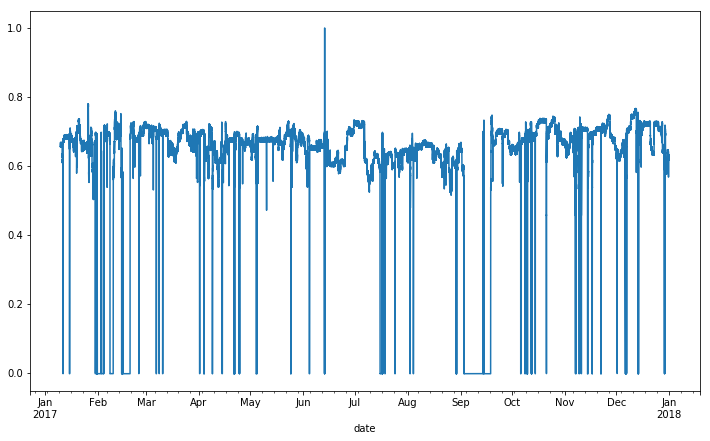

In [33]:
plt.figure(figsize=(12, 7))
(data['ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981']/data['ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981'].max()).plot()
#roll_var_norm.plot()
#plt.scatter(x, [1]*len(x), c='red')

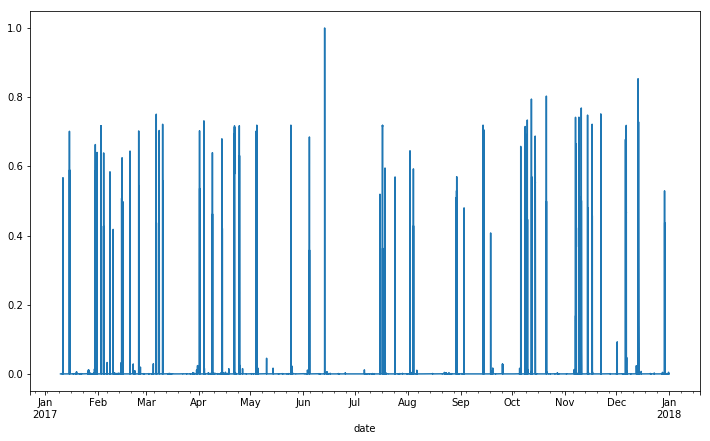

In [34]:
plt.figure(figsize=(12, 7))
roll_var_norm.plot()

In [47]:
roll_var_std = data['ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981'].rolling(int(60*60/10)).std()

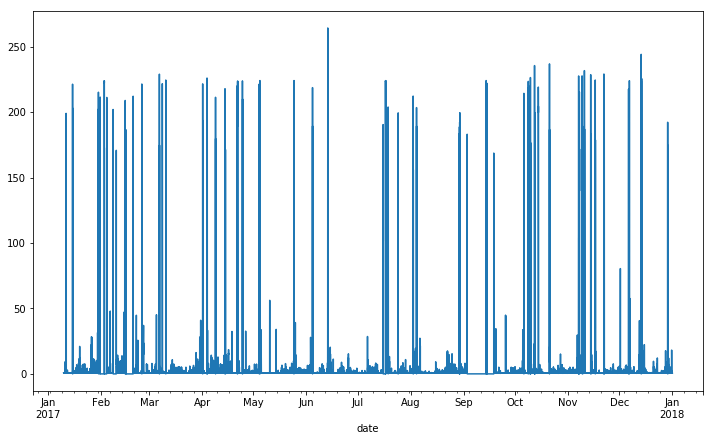

In [48]:
plt.figure(figsize=(12, 7))
roll_var_std.plot()

__________